In [65]:
import re
import os
import copy
from math import log, pow
import subprocess
import matplotlib.pyplot as plt

#### Fault Classes

| Fault | Binary | Decimal |
| --- | --- | --- |
| A | 00 | 0 |
| B | 01 | 1 |
| C | 10 | 2 |
| D | 11 | 3 |

#### Fault Code = (variable << 2) + fault_class

| Fault | Binary | Decimal |
| --- | --- | --- |
| A1 | 100 | 4 |
| B1 | 101 | 5 |
| C1 | 110 | 6 |
| D1 | 111 | 7 |

#### Current Fault Codes

| Fault | Decimal |
| --- | --- |
| A1 | 4 |
| B1 | 5 |
| C1 | 6 |
| D1 | 7 |
| A1B1 | 4-5 |
| A1C1 | 4-6 |
| A1D1 | 4-7 |
| B1C1 | 5-6 |
| C1D1 | 6-7 |

### Build

command = "gcc -g -std=c++17 -I D:/programs/Cadmium-Simulation-Environment/cadmium/include -I D:/programs/Cadmium-Simulation-Environment/DESTimes/include D:/code/C++/RT-Cadmium-FDD/top_model/main.cpp -o D:/code/C++/RT-Cadmium-FDD/top_model/main"
completed_process = subprocess.run(command, shell=False, capture_output=True, text=True)
print(completed_process.returncode)

### Run

In [66]:
command = "D:/code/C++/RT-Cadmium-FDD-New-Code/top_model/main.exe"
completed_process = subprocess.run(command, shell=False, capture_output=True, text=True)
#print(completed_process.stdout)


### Read from file

In [67]:
fileName = "SensorFusion.txt"
    
fault_codes = {}
    
with open(fileName, "r") as f:
    lines = f.readlines()
    
with open(fileName, "r") as f:
    output = f.read()
    
for line in lines:
    if (re.search("supervisor", line) != None):
        res = re.findall("\{\d+[, ]*\d*[, ]*\d*\}", line)

        if len(res) > 0:
            str_interest = res[0].replace('}', '').replace('{', '')
            faults = str_interest.split(', ')
            key = '-' + '-'.join(faults) + '-'
            fault_codes[key] = fault_codes.get(key, 0) + 1

generators = {'A': 0, 'B': 0, 'C': 0, 'D': 0}

for key in generators.keys():
    generators[key] = len(re.findall("faultGen" + key, output))

In [68]:
fault_codes

{'-5-': 45,
 '-7-': 13,
 '-6-': 9,
 '-4-': 8,
 '-4-5-': 4,
 '-5-6-': 5,
 '-4-7-': 2,
 '-4-6-': 2,
 '-6-7-': 2}

### ANALYSIS

### Premise

Fault $A1$: Should have no discarded entry, because it has the highest priority  
Fault $B1$: Should have some discarded value, for the case $BD$, which is not available  
Fault $C1$: Higher percentage of discarded cases than $C$, because of its lower priority  
Fault $D1$: Highest percentage of discarded cases, because it has the lowest priority  

Generator $output_{A1} = n({A1}) + n({A1} \cap {B1}) + n({A1} \cap {C1}) + n({A1} \cap {D1}) + discarded_{A1}$  
Generator $output_{B1} = n({B1}) + n({A1} \cap {B1}) + n({B1} \cap {C1}) + discarded_{B1}$  
Generator $output_{C1} = n({C1}) + n({A1} \cap {C1}) + n({B1} \cap {C1}) + n({C1} \cap {D1}) + discarded_{C1}$  
Generator $output_{D1} = n({D1}) + n({A1} \cap {D1}) + n({C1} \cap {D1}) + discarded_{D1}$  

Where $discarded_{D1} \equiv 0$, because A has the highest priority

In [69]:
def sumFromSupervisor(code):
    '''
    Returns the number of times faults associated with pure fault parameter was output by the supervisor

    @param code: int
    @return int
    '''
    sum = 0
    
    for key, value in fault_codes.items():
        if '-' + str(code) + '-' in key:
            sum += value;
            
    return sum;

In [70]:
a_discarded = generators['A'] - sumFromSupervisor(4)
a_discarded

0

In [71]:
b_discarded = generators['B'] - sumFromSupervisor(5)
b_discarded

1

In [72]:
c_discarded = generators['C'] - sumFromSupervisor(6)
c_discarded

2

In [73]:
d_discarded = generators['D'] - sumFromSupervisor(7)
d_discarded

20

In [74]:
total_discarded = a_discarded + b_discarded + c_discarded + d_discarded

In [75]:
total_generated = generators['A'] + generators['B'] + generators['C'] + generators['D']

In [76]:
discarded_cases = {'A': a_discarded, 'B': b_discarded, 'C': c_discarded, 'D': d_discarded}
discarded_percentage = {'A': a_discarded * 100 / total_generated, 'B': b_discarded * 100 / total_generated, 'C': c_discarded * 100 / total_generated, 'D': d_discarded * 100 / total_generated}

In [77]:
discarded_cases

{'A': 0, 'B': 1, 'C': 2, 'D': 20}

In [78]:
fault_codes

{'-5-': 45,
 '-7-': 13,
 '-6-': 9,
 '-4-': 8,
 '-4-5-': 4,
 '-5-6-': 5,
 '-4-7-': 2,
 '-4-6-': 2,
 '-6-7-': 2}

In [79]:
a_increment = generators['A'] - fault_codes['-4-5-'] - fault_codes['-4-6-'] - fault_codes['-4-7-'] - a_discarded
a_increment

8

In [80]:
b_increment = generators['B'] - fault_codes['-4-5-'] - fault_codes['-5-6-'] - b_discarded
b_increment

45

In [81]:
c_increment = generators['C'] - fault_codes['-4-6-'] - fault_codes['-5-6-'] - fault_codes['-6-7-'] - c_discarded
c_increment

9

In [82]:
d_increment = generators['D'] - fault_codes['-4-7-'] - fault_codes['-6-7-'] - d_discarded
d_increment

13

### Discard Percentage Charts

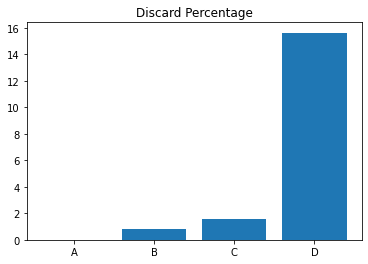

In [83]:
plt.title('Discard Percentage')
plt.bar(discarded_percentage.keys(), discarded_percentage.values())
plt.show()

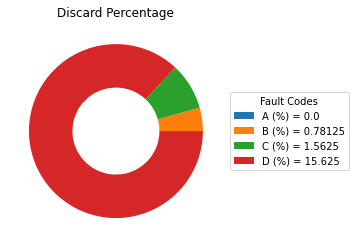

In [84]:
keys, values = list(discarded_percentage.keys()), list(discarded_percentage.values())
legend_keys = copy.copy(keys)

for i in range(len(keys)):
     legend_keys[i] = str(legend_keys[i]) + " (%) = " + str(values[i])

# Remove wedgeprops to make pie
wedges, texts = plt.pie(values, textprops=dict(color="w"), wedgeprops=dict(width=0.5))
plt.legend(wedges, legend_keys,
          title="Fault Codes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Discard Percentage")
plt.show()

### Generator Output Charts (Possibilities of Faults)

In [85]:
generators['D']

37

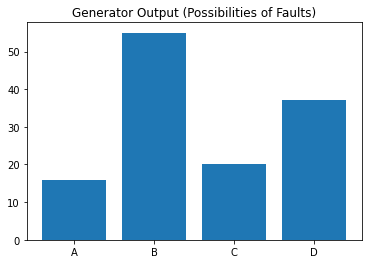

In [86]:
plt.title('Generator Output (Possibilities of Faults)')
plt.bar(generators.keys(), generators.values())
plt.show()

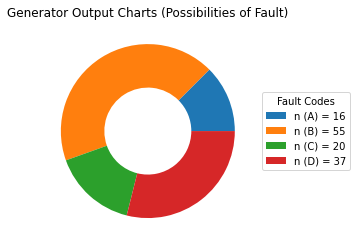

In [87]:
keys, values = list(generators.keys()), list(generators.values())
legend_keys = copy.copy(keys)

for i in range(len(keys)):
     legend_keys[i] = "n (" + str(legend_keys[i]) + ") = " + str(values[i])

# Remove wedgeprops to make pie
wedges, texts = plt.pie(values, textprops=dict(color="w"), wedgeprops=dict(width=0.5))
plt.legend(wedges, legend_keys,
          title="Fault Codes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Generator Output Charts (Possibilities of Fault)")
plt.show()

### Fault Chart

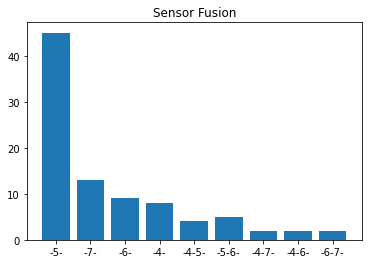

In [88]:
chart_data = copy.copy(fault_codes)
values = list(chart_data.values())
keys = list(chart_data.keys())

plt.title('Sensor Fusion')
plt.bar(keys, values)
plt.show()

### Doughnut

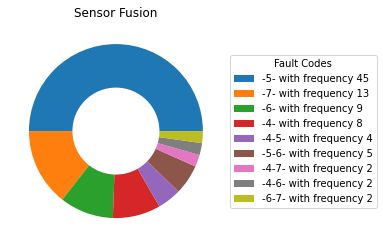

In [89]:
# Remove wedgeprops to make pie
wedges, texts = plt.pie(values, 
                        textprops=dict(color="w"), 
                        wedgeprops=dict(width=0.5))

legend_keys = copy.copy(keys)

for i in range(len(keys)):
     legend_keys[i] = str(legend_keys[i]) + " with frequency " + str(values[i])
        
plt.legend(wedges, legend_keys,
          title="Fault Codes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Sensor Fusion")
plt.show()

### Cumulative

In [90]:
fileName = "D:/code/C++/RT-Cadmium-FDD-New-Code/knowledge_base/_fault_codes_dir/_fault_codes_list.txt"

with open(fileName, "r") as f:
    lines = f.readlines()
    
total = {}
    
for line in lines:
    res = re.findall("\d+[-]*\d*", line)

    if len(res) > 0:
        total[res[0]] = str(res[1])

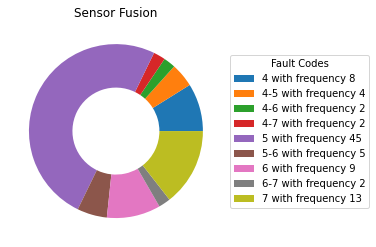

In [91]:
values = list(total.values())
keys = list(total.keys())
legend_keys = copy.copy(keys)

for i in range(len(keys)):
     legend_keys[i] = str(legend_keys[i]) + " with frequency " + str(values[i])

# Remove wedgeprops to make pie
wedges, texts = plt.pie(values, textprops=dict(color="w"), wedgeprops=dict(width=0.5))
plt.legend(wedges, legend_keys,
          title="Fault Codes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Sensor Fusion")
plt.show()

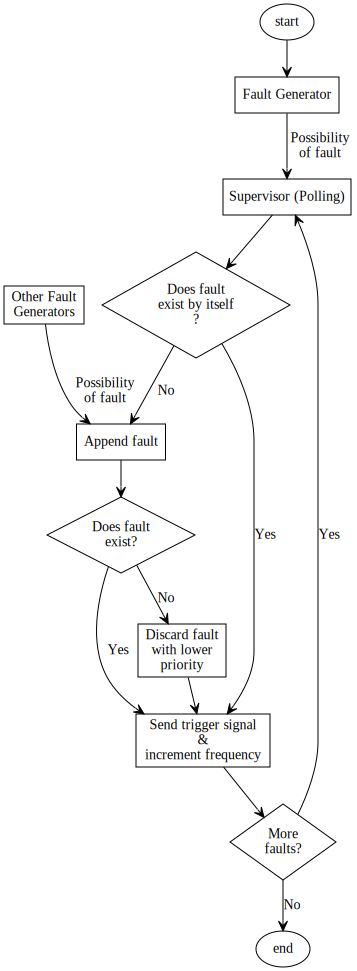

In [92]:
from graphviz import Digraph

dot = Digraph(node_attr={'shape': 'box'})
dot.edge_attr.update(arrowhead='vee', arrowsize='1')

dot.node('0', 'Fault Generator')
dot.node('1', 'Other Fault\nGenerators')
dot.node('2', 'Supervisor (Polling)')
dot.node('3', 'Does fault\n exist by itself\n?' ,shape='diamond')
dot.node('4', 'Send trigger signal \n &\n increment frequency')
dot.node('5', 'Append fault')
dot.node('6', 'Does fault\n exist?', shape='diamond')
dot.node('7', 'Discard fault\nwith lower\npriority')
dot.node('8', 'More\nfaults?', shape='diamond')
dot.node('9', 'end', shape='oval')
dot.node('10', 'start', shape='oval')

dot.edge('0', '2', '  Possibility\nof fault')
dot.edge('1', '5', '  Possibility\nof fault')
dot.edge('2', '3')
dot.edge('3', '4', 'Yes')
dot.edge('3', '5', 'No')
dot.edge('4', '8')
dot.edge('5', '6')
dot.edge('6', '4', 'Yes')
dot.edge('6', '7', 'No')
dot.edge('7', '4')
dot.edge('8', '2', 'Yes')
dot.edge('8', '9', 'No')
dot.edge('10', '0')
dot

### TARGETS

### Quick Search

Since the pure faults are encoded as powers of 2, searching for a pure fault, even in compound faults is done by simply ANDing the fault code with the pure fault code, and checking if the result equals the pure fault code.

### Memory Optimization

The fault codes are in binary, each pure fault is a power of 2, and fault combinations are formed simply by adding the constituent faults. This means that with four pure faults, you only need a nibble to store all fault combinations.

### Fault Code Parser

In [93]:
fault = 2

In [94]:
variable = 1

In [95]:
code = (variable << 8) + fault

In [96]:
code

258

Reverse

In [97]:
fault = code & 15
fault

2

In [98]:
variable = code >> 8
variable

1

In [99]:
a = [1,
2,
3,
4,
5,
6,
8,
9,
12]

In [100]:
b = [x + 16 for x in a]
b

[17, 18, 19, 20, 21, 22, 24, 25, 28]

In [101]:
A1 = (1 << 2) + 0
A1

4

In [102]:
B1 = (1 << 2) + 1
B1

5

In [103]:
C1 = (1 << 2) + 2
C1

6

In [104]:
D1 = (1 << 2) + 3
D1

7

In [105]:
s = {'a' : 1, 'b': 2}

b = s.get('c', 0)
b

0

In [106]:
a = "4"
b = a.split(', ')
b

['4']

In [107]:
test = {'2', '1', '3'}
'-'.join(test)

'3-2-1'

In [108]:
test = ['2']
'-'.join(test)

'2'